In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
df=pd.read_csv("/content/walmart.csv")

In [ ]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


In [ ]:
df.isnull().sum()

,0
User_ID,0
Product_ID,0
Gender,0
Age,0
Occupation,0
City_Category,0
Stay_In_Current_City_Years,0
Marital_Status,0
Product_Category,0
Purchase,0


In [ ]:
df['City_Category'].nunique()

3

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB


In [ ]:
df['Occupation'].value_counts()

,count
Occupation,
4,72308
0,69638
7,59133
1,47426
17,40043
20,33562
12,31179
14,27309
2,26588


In [ ]:
df.describe()

,User_ID,Occupation,Marital_Status,Product_Category,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,23961.000000


In [ ]:
# Calculate key metrics
df['Purchase'] = df['Occupation'] * df['Product_Category']

# Average purchase value per customer
avg_purchase = df.groupby('Product_ID')['Purchase'].mean()
print(avg_purchase.describe())

# Frequency of purchases per customer
purchase_freq = df.groupby('Product_ID')['Product_Category'].count()
print(purchase_freq.describe())

count    3631.000000
mean       52.179009
std        34.861273
min         0.000000
25%        31.437058
50%        45.324675
75%        66.687419
max       256.000000
Name: Purchase, dtype: float64
count    3631.000000
mean      151.492151
std       212.852932
min         1.000000
25%        19.500000
50%        71.000000
75%       194.000000
max      1880.000000
Name: Product_Category, dtype: float64


In [ ]:
# Merge metrics into a single dataframe
customer_df = pd.DataFrame({
    'Product_ID': avg_purchase.index,
    'AvgPurchase': avg_purchase.values,
    'PurchaseFreq': purchase_freq.values
})

# Normalize the data for clustering
scaler = StandardScaler()
customer_df[['AvgPurchase', 'PurchaseFreq']] = scaler.fit_transform(customer_df[['AvgPurchase', 'PurchaseFreq']])


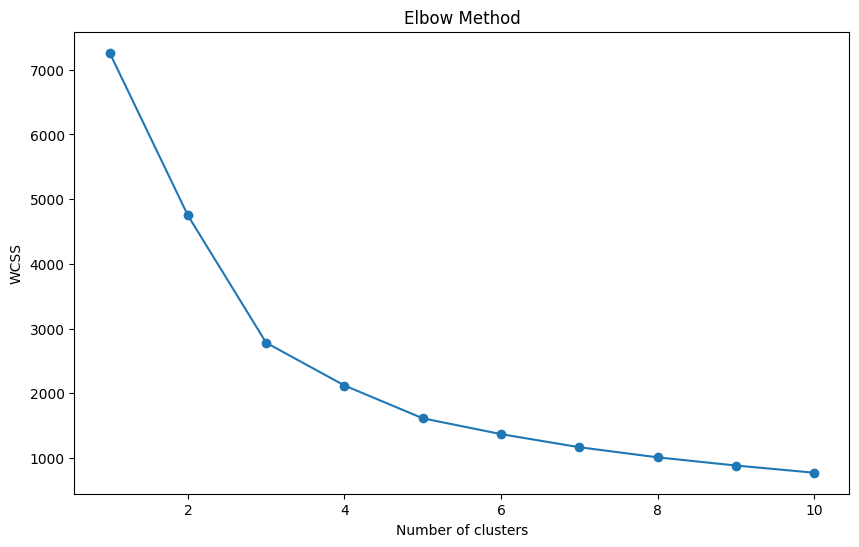

In [ ]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(customer_df[['AvgPurchase', 'PurchaseFreq']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Apply K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
customer_df['Cluster'] = kmeans.fit_predict(customer_df[['AvgPurchase', 'PurchaseFreq']])


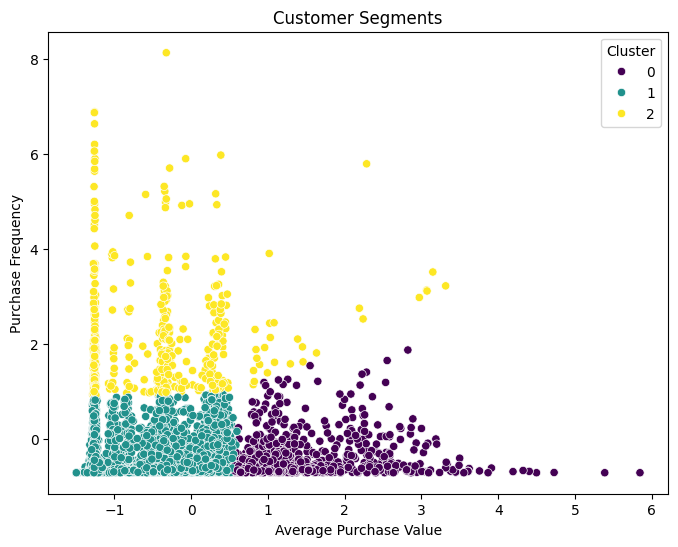

In [ ]:
# Visualize the clusters using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='AvgPurchase', y='PurchaseFreq', hue='Cluster', data=customer_df, palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Average Purchase Value')
plt.ylabel('Purchase Frequency')
plt.show()


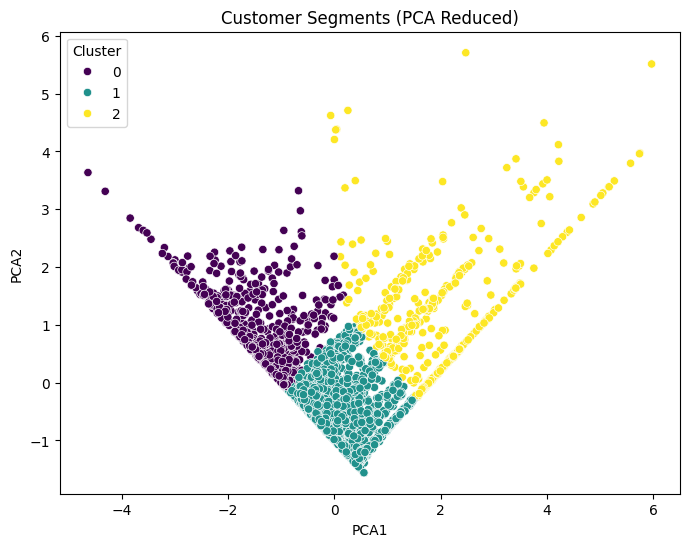

In [ ]:
# Optionally, use PCA for dimensionality reduction if there are more than two features
pca = PCA(n_components=2)
customer_df['PCA1'] = pca.fit_transform(customer_df[['AvgPurchase', 'PurchaseFreq']])[:, 0]
customer_df['PCA2'] = pca.fit_transform(customer_df[['AvgPurchase', 'PurchaseFreq']])[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_df, palette='viridis')
plt.title('Customer Segments (PCA Reduced)')
plt.show()

In [ ]:
# Analyze the characteristics of each segment
cluster_summary = customer_df.groupby('Cluster').agg({
    'AvgPurchase': 'mean',
    'PurchaseFreq': 'mean',
    'Product_ID': lambda x: x.mode()[0]  # Calculate mode for Product_ID as it's categorical
})
print(cluster_summary)

         AvgPurchase  PurchaseFreq Product_ID
Cluster                                      
0           1.517044     -0.386580  P00001842
1          -0.363648     -0.277083  P00000342
2          -0.469180      2.168171  P00000142


In [ ]:
# Provide actionable insights
print("Insights and Recommendations:")
print("1. High-value, frequent customers can be targeted for loyalty programs.")
print("2. Low-value, frequent customers might respond well to upselling or cross-selling.")
print("3. Customers with low frequency but high purchase value could be encouraged to purchase more often through targeted offers.")

Insights and Recommendations:
1. High-value, frequent customers can be targeted for loyalty programs.
2. Low-value, frequent customers might respond well to upselling or cross-selling.
3. Customers with low frequency but high purchase value could be encouraged to purchase more often through targeted offers.
